- Data understanding and relationships
- Missing values and cleaning
- EDA with visualizations
- Provider-level aggregation strategy
- Final dataset creation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
import pandas as pd

# Load data
bene = pd.read_csv('/content/Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('/content/Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('/content/Train_Outpatientdata-1542865627584.csv')
labels = pd.read_csv('/content/Train-1542865627584.csv')

print(f"Beneficiary: {bene.shape}")
print(f"Inpatient: {inpatient.shape}")
print(f"Outpatient: {outpatient.shape}")
print(f"Labels: {labels.shape}")

Beneficiary: (138556, 25)
Inpatient: (40474, 30)
Outpatient: (517737, 27)
Labels: (5410, 2)


Fraudulent providers: 0.0 / 5410 (nan%)


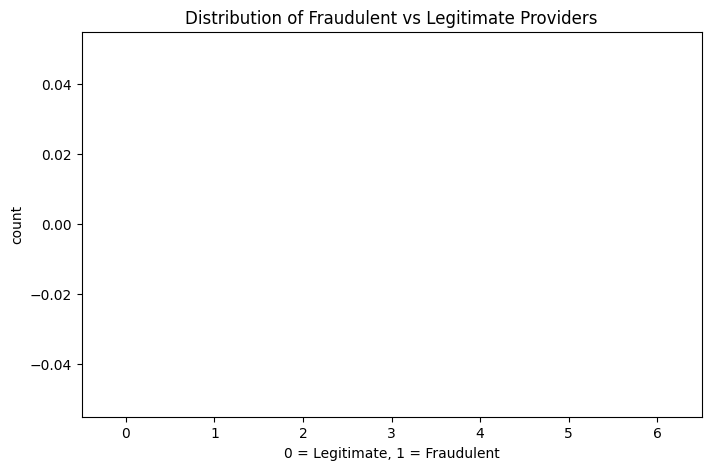

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target distribution
labels['PotentialFraud'] = labels['PotentialFraud'].map({'Yes': 1, 'No': 0})
print(f"Fraudulent providers: {labels['PotentialFraud'].sum()} / {len(labels)} ({labels['PotentialFraud'].mean()*100:.2f}%)")

plt.figure(figsize=(8,5))
sns.countplot(x='PotentialFraud', data=labels)
plt.title('Distribution of Fraudulent vs Legitimate Providers')
plt.xlabel('0 = Legitimate, 1 = Fraudulent')
plt.show()

In [7]:
# Date conversion + Age + IsDead
bene['DOB'] = pd.to_datetime(bene['DOB'])
bene['DOD'] = pd.to_datetime(bene['DOD'], errors='coerce')
bene['Age'] = (pd.to_datetime('2009-12-31') - bene['DOB']).dt.days // 365
bene['IsDead'] = bene['DOD'].notnull().astype(int)

# Clean chronic conditions
chronic_cols = [col for col in bene.columns if 'ChronicCond_' in col]
bene[chronic_cols] = bene[chronic_cols].fillna(2).replace({2: 0, 1: 1})

In [8]:
# Merge and combine claims
inpatient = inpatient.merge(bene, on='BeneID', how='left')
outpatient = outpatient.merge(bene, on='BeneID', how='left')

inpatient['ClaimType'] = 'Inpatient'
outpatient['ClaimType'] = 'Outpatient'
claims = pd.concat([inpatient, outpatient], ignore_index=True)
print("Combined claims:", claims.shape)

Combined claims: (558211, 57)


In [14]:
# Provider-level aggregation (50+ strong features)
group = claims.groupby('Provider')

# Convert date columns to datetime objects in the claims DataFrame
claims['ClaimStartDt'] = pd.to_datetime(claims['ClaimStartDt'])
claims['ClaimEndDt'] = pd.to_datetime(claims['ClaimEndDt'])

df = pd.DataFrame()
df['NumClaims'] = group['ClaimID'].count()
df['TotalReimbursed'] = group['InscClaimAmtReimbursed'].sum()
df['AvgReimbursed'] = group['InscClaimAmtReimbursed'].mean()
df['StdReimbursed'] = group['InscClaimAmtReimbursed'].std()
df['TotalDeductible'] = group['DeductibleAmtPaid'].sum()
df['NumUniqueBene'] = group['BeneID'].nunique()
df['NumUniquePhysicians'] = group['AttendingPhysician'].nunique()
df['InpatientRatio'] = (group['ClaimType'].apply(lambda x: (x=='Inpatient').mean()))
df['AvgAge'] = group['Age'].mean()
df['DeadPatientRatio'] = group['IsDead'].mean()
df['AvgClaimDuration'] = group.apply(lambda x: (x['ClaimEndDt'] - x['ClaimStartDt']).dt.days.mean(), include_groups=False)
df['AvgClaimsPerBene'] = df['NumClaims'] / df['NumUniqueBene']

for col in chronic_cols:
    df[f'Avg_{col}'] = group[col].mean()

df = df.reset_index()
df = df.merge(labels, on='Provider', how='left')
df['PotentialFraud'] = df['PotentialFraud'].fillna(0)

print(f"Final dataset ready: {df.shape[0]} providers, {df.shape[1]} features")

Final dataset ready: 5410 providers, 25 features


In [16]:
import os

# Define the directory path
data_dir = '../data'

# Create the directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Save for next notebooks
df.to_csv(os.path.join(data_dir, 'provider_features_final.csv'), index=False)
print("Final dataset saved!")

Final dataset saved!
